# What's My Flight Status?
***
Author: Andre Layton
***



# Overview
Notes: Construct like an abstract - summary of my entire analysis: 
mention dataset sources, my workflow steps and process, results, evaluations, and conclusions drawn!

# Business Problem

The *Wall Street Journal* recently released their annual airline rankings report, where United Airlines dropped out of the top five. Now at \#6, due to a variety of issues including plane troubles (i.e., the Boeing 737s over the last 8 years), the company’s executive team decided to tackle the issues with growing delays to regain consumer confidence. I’ve been hired to create an algorithm that can predict flight delays, which will be deployed as an app for consumers to be able to track their flights. This is important for both the airline and potential passengers – for the airline, it will help with flight logistics and reduce fees due to delays (i.e. tarmac fees, reimbursements, etc.). For passengers, the app will allow them to make delay arrangements and take measures ahead of time, and possibly save on delay expenses. While delays are frustrating whether expected or not, United aims to use this strategy to display company honesty and gain more control over their flights.

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

## Data Understanding 


In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import math
from IPython.display import HTML
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report,\
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import svm
from sklearn.inspection import permutation_importance
import joblib

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load the flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 10 records
data.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [4]:
# Print column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

In [5]:
# Print airline information
data['CARRIER_NAME'].value_counts()

Southwest Airlines Co.          1296329
Delta Air Lines Inc.             938346
American Airlines Inc.           903640
United Air Lines Inc.            601044
SkyWest Airlines Inc.            584204
Midwest Airline, Inc.            300154
JetBlue Airways                  269596
Alaska Airlines Inc.             239337
American Eagle Airlines Inc.     228792
Comair Inc.                      219324
Endeavor Air Inc.                203827
Spirit Air Lines                 189419
Mesa Airlines Inc.               177600
Frontier Airlines Inc.           120872
Atlantic Southeast Airlines       99044
Hawaiian Airlines Inc.            74898
Allegiant Air                     42636
Name: CARRIER_NAME, dtype: int64

In [6]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

## Data Preparation

In [61]:
# Make a copy of the dataset
data2 = data.copy()

In [62]:
# Filter United Airlines's records and list the first 10
data2 = data2.loc[data2['CARRIER_NAME'] == 'United Air Lines Inc.']
data2.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
21,1,7,0,0800-0859,2,1,25,173,United Air Lines Inc.,13056,...,6,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,1,25,142,United Air Lines Inc.,13056,...,22,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,1,28,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,1,29,142,United Air Lines Inc.,13056,...,19,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
26,1,7,0,0700-0759,1,1,29,154,United Air Lines Inc.,13056,...,21,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
27,1,7,0,0600-0659,2,1,27,154,United Air Lines Inc.,13056,...,20,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
28,1,7,0,0600-0659,9,1,27,173,United Air Lines Inc.,13056,...,11,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
29,1,7,0,0001-0559,5,1,10,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
30,1,7,0,0600-0659,3,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


In [63]:
# Drop unnecessary columns and display column information 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'AVG_MONTHLY_PASS_AIRPORT', 
                'GROUND_SERV_PER_PASS', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'PREVIOUS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
                'LATITUDE', 'LONGITUDE', 'CARRIER_NAME', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601044 entries, 21 to 6489030
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              601044 non-null  int64  
 1   DAY_OF_WEEK        601044 non-null  int64  
 2   DEP_DEL15          601044 non-null  int64  
 3   DEP_TIME_BLK       601044 non-null  object 
 4   DISTANCE_GROUP     601044 non-null  int64  
 5   PLANE_AGE          601044 non-null  int64  
 6   DEPARTING_AIRPORT  601044 non-null  object 
 7   PRCP               601044 non-null  float64
 8   SNOW               601044 non-null  float64
 9   SNWD               601044 non-null  float64
 10  TMAX               601044 non-null  float64
 11  AWND               601044 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 59.6+ MB


In [64]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
21,1,7,0,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91


In [65]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


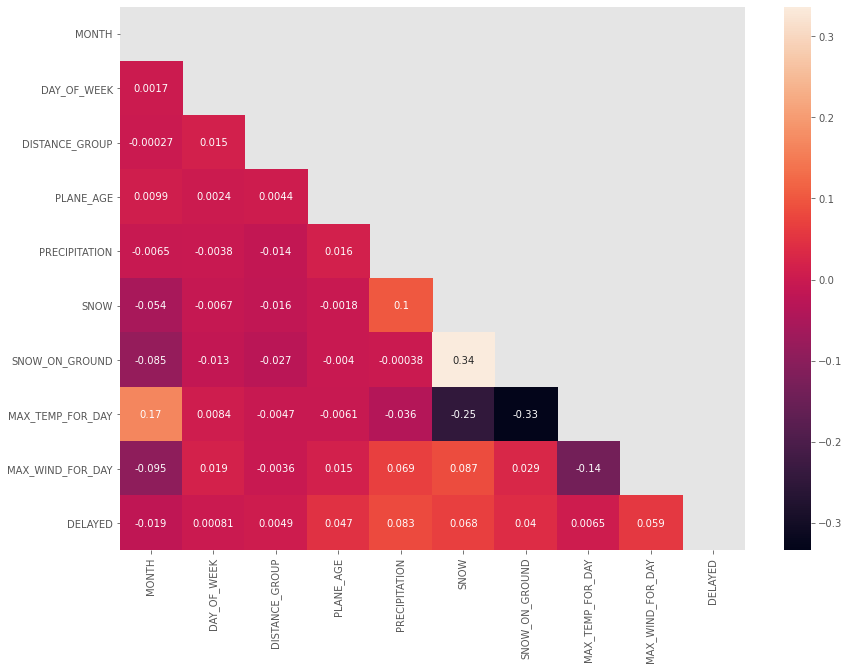

In [66]:
# Plot a heatmap with the Pearson coefficient values listed
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
sns.heatmap(data2.corr(), mask=mask, annot=True);

In [67]:
# Break down the records by month
data2['MONTH'].value_counts().sort_index()

1     44465
2     41598
3     51418
4     50542
5     52644
6     52073
7     53670
8     54066
9     49360
10    53196
11    48450
12    49562
Name: MONTH, dtype: int64

In [68]:
# Break down the records by days of the week
data2['DAY_OF_WEEK'].value_counts().sort_index()

1    89114
2    87840
3    87126
4    87658
5    88782
6    75295
7    85229
Name: DAY_OF_WEEK, dtype: int64

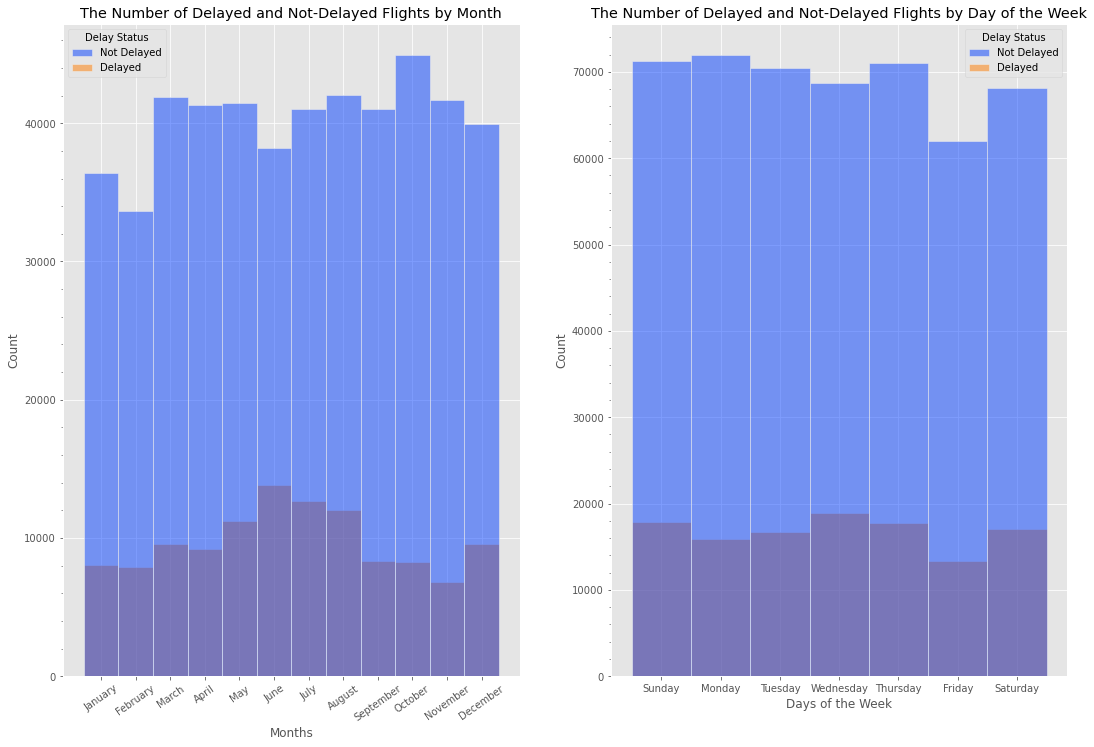

In [69]:
# Plot feature distributions

# Create month and days list objects
months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Visualize the delay status by month
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot1 = sns.histplot(data2, x='MONTH', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot1.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot1.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')
ax[0].tick_params(which="both", bottom=True)

# Change x-tick labels to months (written form) and rotate the labels
old_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax[0].set_xticks(old_labels)
ax[0].set_xticklabels(months)
ax[0].tick_params(axis='x', labelrotation=35)
ax[0].set_xlabel("Months")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Month")
    
# Visualize the delay status by days of the week    
plot2 = sns.histplot(data2, x='DAY_OF_WEEK', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot2.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot2.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to days (written form)
old_labels = [1, 2, 3, 4, 5, 6, 7]
ax[1].set_xticks(old_labels)
ax[1].set_xticklabels(days)
ax[1].set_xlabel("Days of the Week")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Day of the Week");

In [70]:
# Break down the records by departure time blocks
data2['DEP_TIME_BLK'].value_counts().sort_index()

0001-0559    10267
0600-0659    42704
0700-0759    48374
0800-0859    44230
0900-0959    38512
1000-1059    36435
1100-1159    35991
1200-1259    35918
1300-1359    29069
1400-1459    34400
1500-1559    30829
1600-1659    35741
1700-1759    37217
1800-1859    37925
1900-1959    35563
2000-2059    22733
2100-2159    20523
2200-2259    13236
2300-2359    11377
Name: DEP_TIME_BLK, dtype: int64

In [71]:
# Break down the records by distance group
data2['DISTANCE_GROUP'].value_counts().sort_index()

1      30152
2      68733
3      83959
4     118255
5      67136
6      47831
7      62163
8      24036
9      16434
10     51936
11     30409
Name: DISTANCE_GROUP, dtype: int64

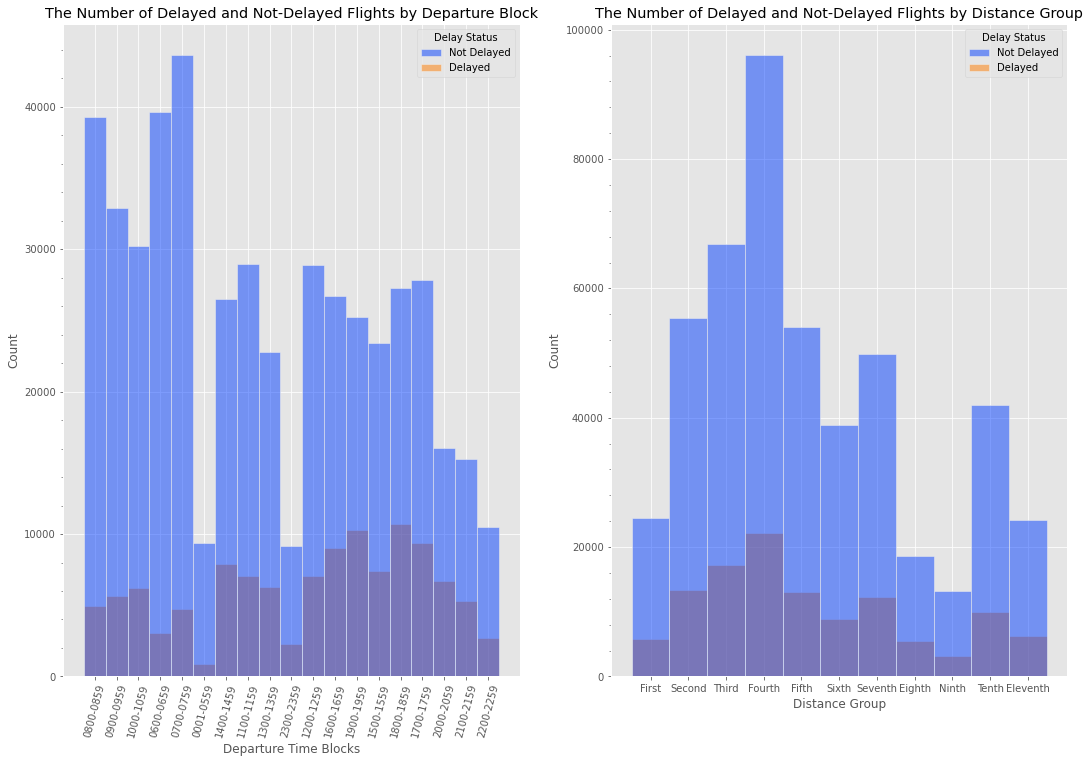

In [72]:
# Plot feature distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Visualize the delay status by departure time block
plot3 = sns.histplot(data2, x='DEP_TIME_BLK', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot3.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot3.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')

# Rotate x-tick labels
ax[0].tick_params(axis='x', labelrotation=75)
ax[0].tick_params(which="both", bottom=True)
ax[0].set_xlabel("Departure Time Blocks")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Departure Block")
    
# Visualize the delay status by distance group  
plot4 = sns.histplot(data2, x='DISTANCE_GROUP', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot4.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot4.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to distance group (written form)
num_xlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
str_xlabels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh']
ax[1].set_xticks(num_xlabels)
ax[1].set_xticklabels(str_xlabels)
ax[1].set_xlabel("Distance Group")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Distance Group");

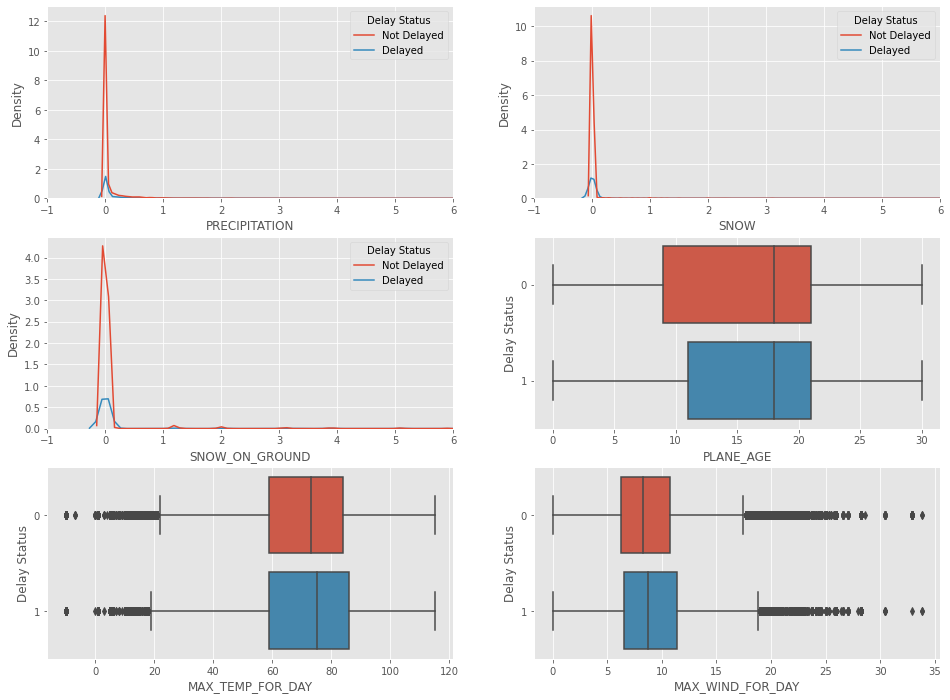

In [73]:
# Plot the remaining continuous variables with the delay status 
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
kde1 = sns.kdeplot(data=data2, x="PRECIPITATION", hue="DELAYED", ax=ax[0,0])
kde2 = sns.kdeplot(data=data2, x="SNOW", hue="DELAYED", ax=ax[0,1])
kde3 = sns.kdeplot(data=data2, x="SNOW_ON_GROUND", hue="DELAYED", ax=ax[1,0])
box1 = sns.boxplot(data=data2, x="PLANE_AGE", y="DELAYED", orient='h', ax=ax[1,1])
box2 = sns.boxplot(data=data2, x="MAX_TEMP_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,0])
box3 = sns.boxplot(data=data2, x="MAX_WIND_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,1]);

kdeplots = [kde1, kde2, kde3]
for plot in kdeplots:
    new_title = 'Delay Status'
    plot.legend_.set_title(new_title)
    new_labels = ['Not Delayed', 'Delayed']
    for t, l in zip(plot.legend_.texts, new_labels):
        t.set_text(l)
    plot.set_xlim(-1, 6) 

boxplots = [box1, box2, box3]
for boxplot in boxplots:
    boxplot.set(ylabel='Delay Status')

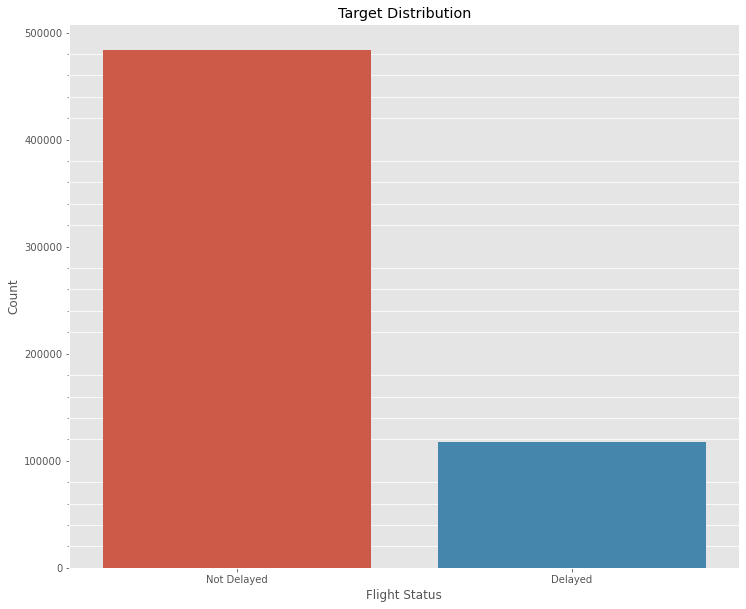

In [74]:
# Visualize the class (target) distribution
fig, ax = plt.subplots(figsize=(12,10))

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_axisbelow(True)
plt.grid(which='both')

# Plot the target 
sns.countplot(data=data2, x='DELAYED', orient='v')
ax.set_title('Target Distribution')

# Change x-tick labels 
old_labels = [0, 1]
new_xlabels = ['Not Delayed', 'Delayed']
ax.set_xticks(old_labels)
ax.set_xticklabels(new_xlabels)

ax.set_xlabel("Flight Status")
ax.set_ylabel("Count");

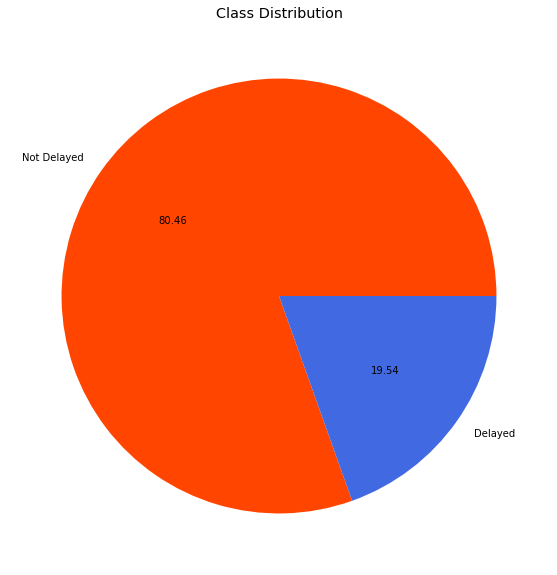

In [75]:
fig, ax = plt.subplots(figsize=(12, 10))
data2['DELAYED'].value_counts().plot.pie(autopct='%.2f', title='Class Distribution', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

### Further Preprocessing:

In [76]:
cols_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'DEPARTING_AIRPORT']
data2_enc = pd.get_dummies(data2, columns=cols_to_encode)

In [110]:
data2_enc.head()

,PLANE_AGE,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED,MONTH_1,MONTH_2,MONTH_3,...,DEPARTING_AIRPORT_Standiford Field,DEPARTING_AIRPORT_Stapleton International,DEPARTING_AIRPORT_Syracuse Hancock International,DEPARTING_AIRPORT_Tampa International,DEPARTING_AIRPORT_Theodore Francis Green State,DEPARTING_AIRPORT_Truax Field,DEPARTING_AIRPORT_Tucson International,DEPARTING_AIRPORT_Tulsa International,DEPARTING_AIRPORT_Washington Dulles International,DEPARTING_AIRPORT_Will Rogers World
21,6,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22,22,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
23,3,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,19,0.0,0.0,0.0,65.0,2.91,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,4,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
y = data2_enc['DELAYED']
X = data2_enc.drop('DELAYED', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
X_train.shape

(450783, 139)

In [112]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=seed)
X_val.shape

(75131, 139)

In [113]:
rus = RandomUnderSampler(sampling_strategy=1, random_state=seed) # Numerical value
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

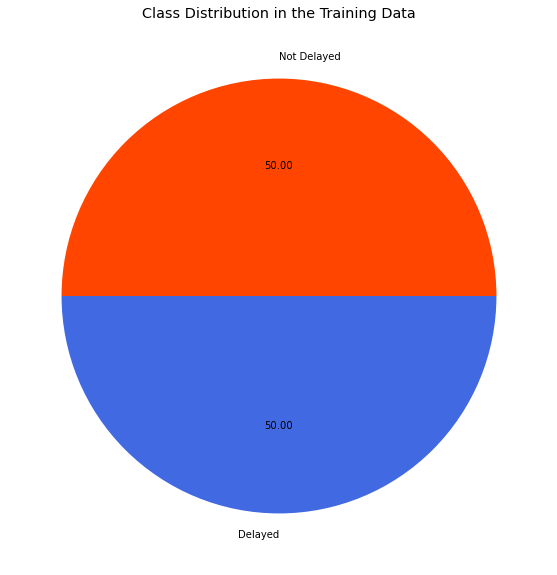

In [114]:
fig, ax = plt.subplots(figsize=(12, 10))
y_train_res.value_counts().plot.pie(autopct='%.2f', title='Class Distribution in the Training Data', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

In [115]:
X_train_res.shape

(175768, 139)

In [116]:
# Use the StandardScaler function to scale the data
cols = X_train_res.columns

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns = cols)
X_val = pd.DataFrame(X_val_scaled, columns = cols)
X_test = pd.DataFrame(X_test_scaled, columns = cols)

# Check & reconfirm the training data's shape
X_train.shape

(175768, 139)

## Modeling
### Baseline Model:

In [117]:
# Create a baseline model - a Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=seed, class_weight='balanced')
tree_clf.fit(X_train, y_train_res)

# Predict estimates for both training & test sets
y_train_hat = tree_clf.predict(X_train)
y_val_hat = tree_clf.predict(X_val)

# Print the accuracy and precision scores for both sets of data
print("Training Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_train_res, y_train_hat) * 100))
print("Validation Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_val, y_val_hat) * 100))
print('')
print("Training Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_train_res, y_train_hat) * 100))
print("Validation Precision for Decision Tree Classifier: {:.4}%".format(precision_score(y_val, y_val_hat) * 100))

Training Accuracy for Decision Tree Classifier: 61.9%
Validation Accuracy for Decision Tree Classifier: 56.51%

Training Precision for Decision Tree Classifier: 60.31%
Validation Precision for Decision Tree Classifier: 26.59%


In [85]:
# Print the classification report
print(f'Decision Tree: \n{classification_report(y_val, y_val_hat)}')

Decision Tree: 
              precision    recall  f1-score   support

           0       0.87      0.54      0.66     60329
           1       0.27      0.69      0.38     14802

    accuracy                           0.57     75131
   macro avg       0.57      0.61      0.52     75131
weighted avg       0.75      0.57      0.61     75131



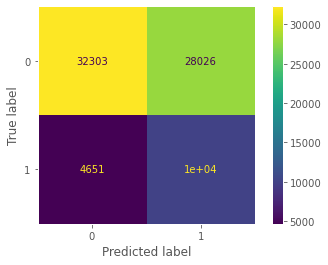

In [86]:
# Plot the confusion matrix 
cm = confusion_matrix(y_val, y_val_hat, labels=tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

In [87]:
# Generate a sorted dictionary listing the feature importances
feature_rankings = {}
for fi, feature in sorted(zip(tree_clf.feature_importances_, X_train.columns), reverse=True):
    feature_rankings[feature] = fi
print(feature_rankings)

{'PRECIPITATION': 0.18501812631329656, 'DEP_TIME_BLK_0600-0659': 0.15638735922365055, 'DEP_TIME_BLK_0700-0759': 0.1340838915055432, 'DEP_TIME_BLK_0800-0859': 0.10942992895995451, 'PLANE_AGE': 0.04809636575019646, 'DEP_TIME_BLK_0001-0559': 0.04386018821082445, 'MONTH_6': 0.038626805453963055, 'DEP_TIME_BLK_0900-0959': 0.03779864061750279, 'MAX_WIND_FOR_DAY': 0.03494419499053588, 'MAX_TEMP_FOR_DAY': 0.030781794570239773, 'SNOW': 0.017684941982034637, 'DEP_TIME_BLK_1000-1059': 0.015070548639423184, 'DEPARTING_AIRPORT_Newark Liberty International': 0.014778889173053953, 'SNOW_ON_GROUND': 0.014718877534608075, 'MONTH_11': 0.014074823883391391, 'DEPARTING_AIRPORT_San Francisco International': 0.01268731781365928, 'MONTH_10': 0.009534653900477, "DEPARTING_AIRPORT_Chicago O'Hare International": 0.006738133872576363, 'DEPARTING_AIRPORT_Houston Intercontinental': 0.0065370692171220456, 'DAY_OF_WEEK_4': 0.003994746575165737, 'DEPARTING_AIRPORT_Stapleton International': 0.0037379091403939753, 'DEP

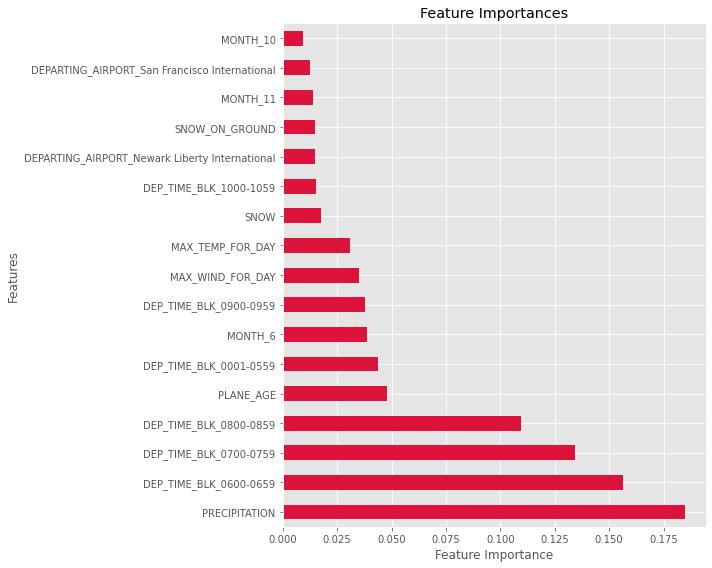

In [95]:
# Visualize the feature importances
importances = tree_clf.feature_importances_
important_features = pd.Series(importances, index=X_train.columns)


fig, ax = plt.subplots(figsize=(10, 8))
important_features.nlargest(17).plot(kind='barh', color='crimson')
ax.set_title("Feature Importances")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Features")
fig.tight_layout()

In [103]:
# Create a Random Forests model & evaluate both sets' accuracies
forest = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=seed)
forest.fit(X_train, y_train_res)

# Predict estimates for both sets of data
y_train_hat = forest.predict(X_train)
y_val_hat = forest.predict(X_val)

# Print precision scores
print("Training Precision for Random Forest Classifier: {:.4}%".format(precision_score(y_train_res, y_train_hat) * 100))
print("Validation Precision for Random Forest Classifier: {:.4}%".format(precision_score(y_val, y_val_hat) * 100))

Training Precision for Random Forest Classifier: 63.34%
Validation Precision for Random Forest Classifier: 28.72%


In [104]:
# Print the classification report
print(f'Decision Tree: \n{classification_report(y_val, y_val_hat)}')

Decision Tree: 
              precision    recall  f1-score   support

           0       0.87      0.62      0.72     60329
           1       0.29      0.63      0.39     14802

    accuracy                           0.62     75131
   macro avg       0.58      0.62      0.56     75131
weighted avg       0.76      0.62      0.66     75131



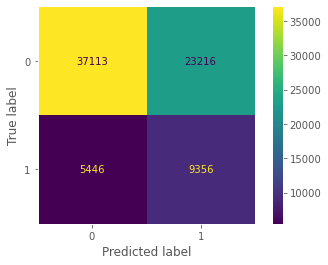

In [97]:
# Plot the confusion matrix 
cm = confusion_matrix(y_val, y_val_hat, labels=tree_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=tree_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

In [106]:
# Create a Gradient Boosting classifier model 
gbt_clf = GradientBoostingClassifier(random_state=seed)
gbt_clf.fit(X_train, y_train_res)

# Predict estimates
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_val)

print("Training Precision for Gradient Boosted Classifier: {:.4}%".format(precision_score(y_train_res, gbt_clf_train_preds) * 100))
print("Validation Precision for Gradient Boosted Classifier: {:.4}%".format(precision_score(y_val, gbt_clf_test_preds) * 100))

Training Precision for Gradient Boosted Classifier: 62.3%
Validation Precision for Gradient Boosted Classifier: 28.53%


In [107]:
# Print the classification report
print(f'Decision Tree: \n{classification_report(y_val, gbt_clf_test_preds)}')

Decision Tree: 
              precision    recall  f1-score   support

           0       0.88      0.60      0.71     60329
           1       0.29      0.65      0.40     14802

    accuracy                           0.61     75131
   macro avg       0.58      0.63      0.55     75131
weighted avg       0.76      0.61      0.65     75131



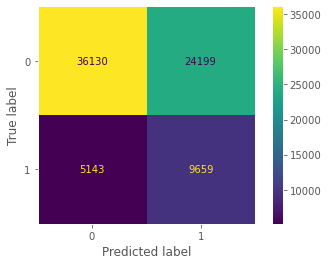

In [109]:
# Plot the confusion matrix 
cm = confusion_matrix(y_val, gbt_clf_test_preds, labels=gbt_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gbt_clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

## Evaluation

## Conclusion

## Limitations/Further Work

In [19]:
# List (and sort) the value counts of each departure time block
#value_counts = data2['DEP_TIME_BLK'].value_counts().sort_index()

# Create a dictionary that represents each unique time block with a number
#block_number = {value: i for i, value in enumerate(value_counts.index)}

# Replace each time block with its corresponding unique value
#data2["DEP_TIME_BLK"] = data2["DEP_TIME_BLK"].map(block_number)
#data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,3,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,3,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,4,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,5,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,1,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


In [20]:
# List (and sort) the value counts of each departing airport
#value_counts_airports = data2['DEPARTING_AIRPORT'].value_counts().sort_index()

# Create a dictionary that associates each unique airport with a unique number
#airport_number = {value: i for i, value in enumerate(value_counts_airports.index)}

# Replace each departing airport with its corresponding unique value
#data2['DEPARTING_AIRPORT'] = data2['DEPARTING_AIRPORT'].map(airport_number)
#data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,3,2,6,38,0.0,0.0,0.0,65.0,2.91,0
22,1,7,3,3,22,38,0.0,0.0,0.0,65.0,2.91,0
23,1,7,4,7,3,38,0.0,0.0,0.0,65.0,2.91,0
24,1,7,5,3,19,38,0.0,0.0,0.0,65.0,2.91,1
25,1,7,1,7,4,38,0.0,0.0,0.0,65.0,2.91,0


In [50]:
#pca = PCA(n_components=50, random_state=seed)
#pca_train = pca.fit_transform(X_train)
#pca_val = pca.transform(X_val)
#pca_test = pca.transform(X_test)
#print(np.sum(pca.explained_variance_ratio_)*100)

91.07474094913754


In [52]:
#X_train = pd.DataFrame(pca_train)
#X_val = pd.DataFrame(pca_val)
#X_test = pd.DataFrame(pca_test)
#X_train.shape

(175768, 50)

## Sources
Link to original dataset: 
https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations/data?select=full_data_flightdelay.csv

Wall Street Journal annual airlines ranking report:
https://www.wsj.com/lifestyle/travel/best-airlines-us-2023-36e9ea20

